In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D,UpSampling2D

In [2]:
np.random.seed(42)
tf.random.set_seed(42)
batch_size = 256
max_epochs = 50
filters = [32, 32, 16]

In [3]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

x_train = x_train / 255.
x_test = x_test / 255.

x_train = np.reshape(x_train, (len(x_train),28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

noise = 0.5

x_train_noisy = x_train + noise * np.random.normal(loc=0.0,scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise * np.random.normal(loc=0.0,scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0, 1)
x_test_noisy = np.clip(x_test_noisy, 0, 1)

x_train_noisy = x_train_noisy.astype('float32')
x_test_noisy = x_test_noisy.astype('float32')


11493376/11490434 [==============================] - 0s 0us/step


In [4]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, filters):
        super(Encoder, self).__init__()
        self.conv1 = Conv2D(filters = filters[0], kernel_size = 3,
strides = 1, padding = 'same', activation = 'relu', input_shape = (28, 28, 1))
        self.conv2 = Conv2D(filters = filters[1], kernel_size = 3,
strides = 1, padding = 'same', activation = 'relu')
        self.conv3 = Conv2D(filters = filters[2], kernel_size = 3,
strides = 1, padding = 'same', activation = 'relu')
        self.pool = MaxPooling2D((2,2), padding = 'same')
        
    def call(self, input_features):
        x = self.conv1(input_features)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.pool(x)
        return x

In [5]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, filters):
        super(Decoder, self).__init__()
        self.conv1 = Conv2D(filters = filters[2], kernel_size = 3,
strides = 1, activation = 'relu', padding = 'same')
        self.conv2 = Conv2D(filters = filters[1], kernel_size = 3,
strides = 1, padding = 'same', activation = 'relu')
        self.conv3 = Conv2D(filters = filters[0], kernel_size = 3,
strides = 1, padding = 'valid', activation = 'relu')
        self.conv4 = Conv2D(1, 3, 1, activation = 'sigmoid', padding = 'same')
        self.upsample = UpSampling2D((2,2))
    def call(self, encoded):
        x = self.conv1(encoded)
#         print("conv1", x.shape)
        x = self.upsample(x)
#         print("ups1", x.shape)
        x = self.conv2(x)
#         print("conv2", x.shape)
        x = self.upsample(x)
#         print("ups2", x.shape)
        x = self.conv3(x)
#         print("conv3", x.shape)
        x = self.upsample(x)
#         print("ups3", x.shape)
        x = self.conv4(x)
#         print("conv4", x.shape)
        return x

In [6]:
class Autoencoder(tf.keras.Model):
    def __init__(self, filters):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(filters)
        self.decoder = Decoder(filters)
        
    def call(self, input_features):
        #print(input_features.shape)
        encoded = self.encoder(input_features)
#         print('encoded.shape', encoded.shape)
        reconstructed = self.decoder(encoded)
#         print('reconstructed.shape', reconstructed.shape)
        return reconstructed

In [7]:
model = Autoencoder(filters)
model.compile(loss = 'binary_crossentropy', optimizer = 'adam')

In [8]:
history = model.fit(x_train_noisy,
                    x_train,
                    validation_data = (x_test_noisy, x_test),
                    epochs = max_epochs,
                    batch_size = batch_size)

Epoch 1/50
235/235 [==============================] - 36s 27ms/step - loss: 0.2478 - val_loss: 0.1756
Epoch 2/50
235/235 [==============================] - 6s 25ms/step - loss: 0.1627 - val_loss: 0.1508
Epoch 3/50
235/235 [==============================] - 6s 25ms/step - loss: 0.1461 - val_loss: 0.1395
Epoch 4/50
235/235 [==============================] - 6s 25ms/step - loss: 0.1374 - val_loss: 0.1328
Epoch 5/50
235/235 [==============================] - 6s 25ms/step - loss: 0.1318 - val_loss: 0.1288
Epoch 6/50
235/235 [==============================] - 6s 25ms/step - loss: 0.1278 - val_loss: 0.1247
Epoch 7/50
235/235 [==============================] - 6s 25ms/step - loss: 0.1250 - val_loss: 0.1224
Epoch 8/50
235/235 [==============================] - 6s 25ms/step - loss: 0.1223 - val_loss: 0.1204
Epoch 9/50
235/235 [==============================] - 6s 25ms/step - loss: 0.1204 - val_loss: 0.1181
Epoch 10/50
235/235 [==============================] - 6s 25ms/step - loss: 0.1186 - val_l

Text(0, 0.5, 'Loss')

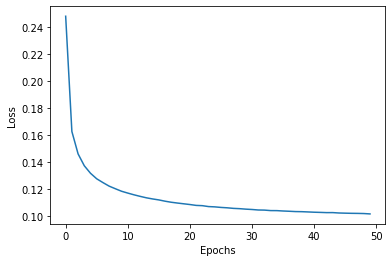

In [9]:
plt.plot(history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')

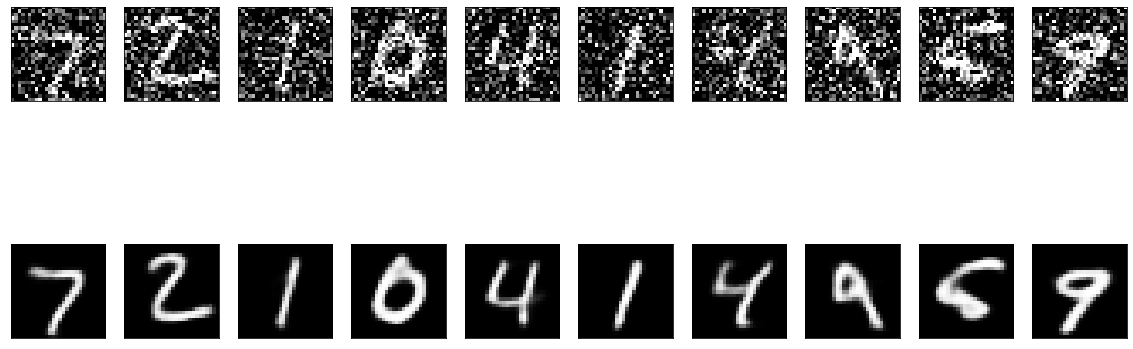

In [11]:
number = 10
reconstructed = model(x_test_noisy).numpy()
plt.figure(figsize = (20, 8))
for index in range(number):
  ax = plt.subplot(2, number, index + 1)
  plt.imshow(x_test_noisy[index].reshape(28, 28), cmap = 'gray')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(2, number, index + 1 + number)
  plt.imshow(reconstructed[index].reshape(28, 28), cmap = 'gray')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()